In [1]:
import sys
sys.path.append('..')

In [2]:
import planetengine
import modelscripts

In [3]:
from planetengine import quickShow

In [13]:
system = modelscripts.isovisc_systemscript.build(aspect = 7, res = 4)

Fitted 0 variables to the figure.



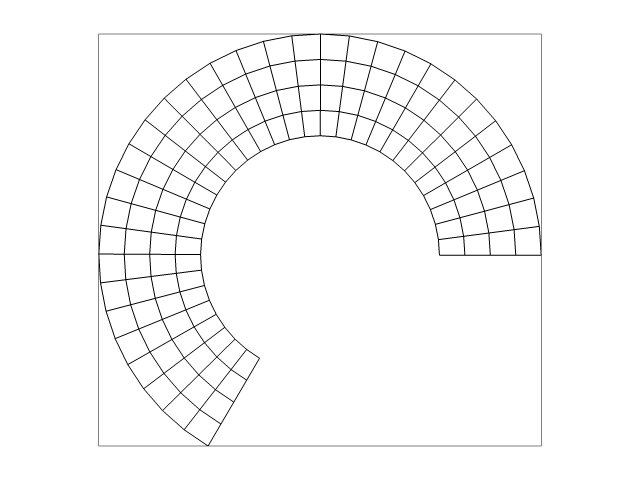

In [14]:
quickShow(system.mesh)

In [21]:
boxDims = ((0., 1.),) * system.mesh.dim
angBox = system.mesh.add_variable(1)
newAngBox = system.mesh.add_variable(1)
box = planetengine.mapping.box(system.mesh, system.mesh.data, boxDims)
angBox.data[:] = box[:,0].reshape(angBox.data.shape)

[[0.0, 239.6005325092533], (1.1739130434782612, 2.173913043478261)]


Fitted 1 variables to the figure.



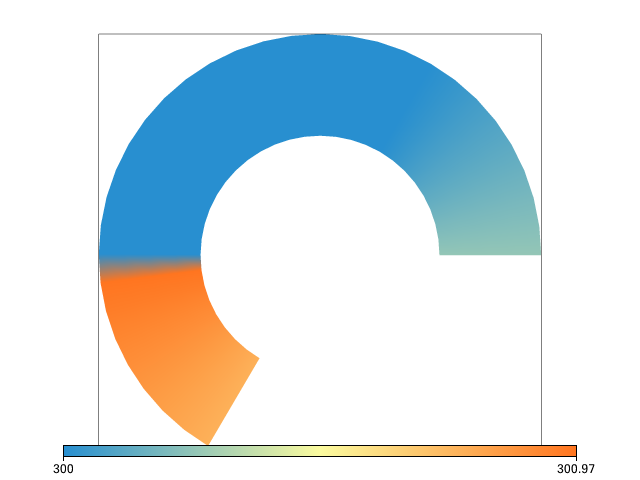

In [27]:
quickShow(angBox)

In [17]:
def rotate_coords(
        coordArray,
        rotation
        ):
    # rotation is in degrees;
    # positive is anticlockwise
    angs, rads = coordArray.transpose()
    angs += rotation
    outArray = np.dstack((angs, rads))[0]
    return outArray

In [26]:
angBox.data[:] = rotate_coords(box, 100.)[:,0].reshape(angBox.data.shape)

In [24]:
import numpy as np

In [ ]:
xs, ys = system.mesh.data.transpose()
newAngBox.data[:] = np.vstack(np.arctan2(ys, xs) * 180. / np.pi)

In [ ]:
quickShow(newAngBox)

In [ ]:
newAngBox.data[:] = planetengine.mapping.rescale_array(newAngBox.data, planetengine.mapping.get_scales(newAngBox.data), [[0., 1]])

In [ ]:
quickShow(newAngBox)

In [ ]:
from planetengine.mapping import rescale_array
from planetengine.mapping import radial_coords
from planetengine.mapping import get_scales

coordArray = system.mesh.data

radialCoords = radial_coords(coordArray)
inScales = get_scales(radialCoords)
outScales = boxDims
outArray = rescale_array(
    radialCoords,
    inScales,
    outScales,
    flip = [True, False]
    )

newAngBox.data[:] = outArray[:,0].reshape(newAngBox.data.shape)

In [ ]:
quickShow(newAngBox)

In [ ]:
system.mesh.angularExtent

In [ ]:
system.mesh.radialLengths